<a href="https://colab.research.google.com/github/KOMBOU12/Marius/blob/main/ACP_Robuste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

def medians_of_means(X, num_blocks):
    """
    Calcul la moyenne de chaque bloc, puis la médiane des moyennes.

    X : ndarray
        Données à traiter, de forme (n_samples, n_features)
    num_blocks : int
        Nombre de blocs à utiliser pour le calcul MoM

    Retour :
    X_mom : ndarray
        Estimation robuste des données par Medians of Means
    """
    n_samples, n_features = X.shape
    assert n_samples >= num_blocks, "Le nombre de blocs doit être inférieur ou égal au nombre d'échantillons"

    # Mélanger les données pour éviter les effets d'ordre
    np.random.shuffle(X)

    # Diviser les données en blocs
    block_size = n_samples // num_blocks
    blocks = np.array_split(X, num_blocks)

    # Calculer la moyenne de chaque bloc
    block_means = np.array([np.mean(block, axis=0) for block in blocks])

    # Calculer la médiane des moyennes
    X_mom = np.median(block_means, axis=0)

    return X_mom

def robust_pca(X, num_components=2, num_blocks=10):
    """
    Effectuer une ACP robuste en utilisant la méthode Medians of Means.

    X : ndarray
        Données à traiter, de forme (n_samples, n_features)
    num_components : int
        Nombre de composantes principales à calculer
    num_blocks : int
        Nombre de blocs pour l'estimation MoM

    Retour :
    X_pca : ndarray
        Données projetées dans l'espace des composantes principales
    pca : PCA
        Modèle PCA ajusté
    """
    # On centre les données en utilisant Medians of Means
    X_centered = X - medians_of_means(X, num_blocks)

    # On applique l'ACP sur les données centrées
    pca = PCA(n_components=num_components)
    X_pca =  pca.fit_transform(X_centered)

    return X_pca, pca

# Exemple d'utilisation
if __name__ == "__main__":
    # Génére des données synthétiques
    np.random.seed(42)
    X = np.random.randn(100, 5)  # 100 échantillons, 5 features

    # Ajoute des valeurs aberrantes
    X[:5] += 10

    # Effectue une ACP robuste
    X_pca, pca_model = robust_pca(X, num_components=2, num_blocks=10)

    #print("Composantes principales:\n", X_pca)
    #print("Variance expliquée:", pca_model.explained_variance_ratio_)


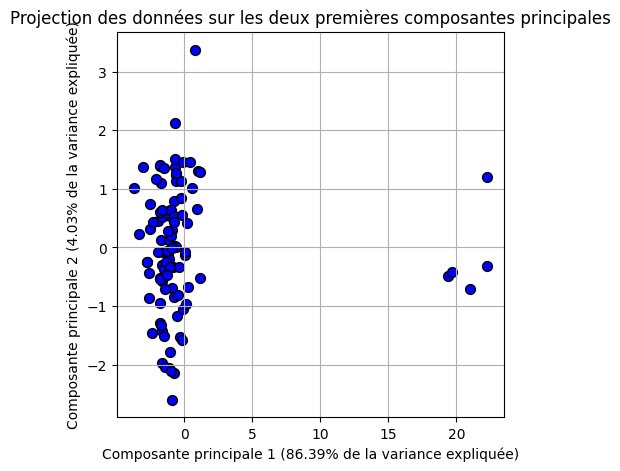

In [ ]:
import matplotlib.pyplot as plt


# Représentation des données projetées sur les deux premières composantes principales
plt.figure(figsize=(5, 5))

# Nuage de points des données projetées
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k', s=50)

# Ajouter des labels et un titre
plt.xlabel(f'Composante principale 1 ({pca_model.explained_variance_ratio_[0]*100:.2f}% de la variance expliquée)')
plt.ylabel(f'Composante principale 2 ({pca_model.explained_variance_ratio_[1]*100:.2f}% de la variance expliquée)')
plt.title('Projection des données sur les deux premières composantes principales')

# Afficher la figure
plt.grid(True)
plt.show()

Les outliers (5 premiers points) que j'ai ajouté ont un impact majeur sur la première composante principale, expliquant pourquoi cette composante capture la majorité de la variance.

La deuxième composante principale ne capte que peu de variance, ce qui indique que la structure des données sans outliers est relativement simple et que la plupart des variations sont dans une seule direction (capturée par CP1).

Le graphique montre clairement la séparation entre les valeurs aberrantes et les données normales, avec les outliers se distinguant par leurs valeurs extrêmement élevées sur la composante principale 1.

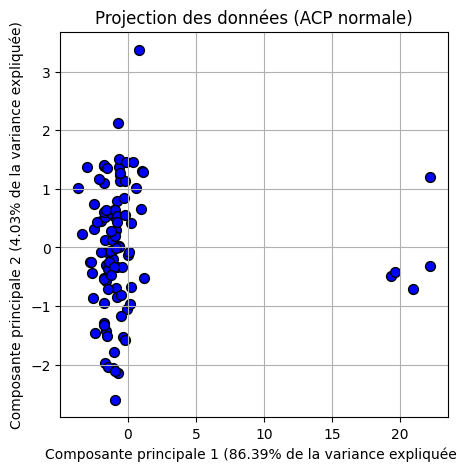

In [ ]:
# Faire l'ACP normale
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Variance expliquée
explained_variance = pca.explained_variance_ratio_

# Affichage graphique
plt.figure(figsize=(5, 5))

# Représenter les données projetées sur les deux premières composantes
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k', s=50)

# Ajouter des labels et un titre
plt.xlabel(f'Composante principale 1 ({explained_variance[0]*100:.2f}% de la variance expliquée)')
plt.ylabel(f'Composante principale 2 ({explained_variance[1]*100:.2f}% de la variance expliquée)')
plt.title('Projection des données (ACP normale)')


# Afficher la figure
plt.grid(True)
plt.show()


Les deux graphiques  semblent  très similaires, à la fois pour l'ACP normale et l'ACP robuste. Cela peut paraître surprenant, car en théorie, l'ACP robuste devrait minimiser l'impact des outliers.

Bien que l'ACP robuste soit conçue pour minimiser l'effet des outliers, dans ce cas précis, les outliers sont suffisamment importants pour influencer les résultats, même avec cette méthode.

In [ ]:
import numpy as np

def median_of_means(groups):
    """Compute the Median of Means for the given groups."""
    means = [np.mean(group) for group in groups]
    return np.median(means)

def partition_data(X, K):
    """Partition the data into K equally sized random subsets."""
    np.random.shuffle(X)  # Shuffle the data
    return np.array_split(X, K)

def compute_gradient(X, v, I_k):
    """Compute the gradient ∇φ(v) = 2 * (K/N) * Σ(x_i * x_i^T * v) for the selected partition I_k."""
    gradient = np.zeros_like(v)
    for x_i in X[I_k]:
        gradient += np.outer(x_i, x_i).dot(v)
    return 2 * gradient / len(X)

def normalize(v):
    """Normalize the vector v to have a unit norm."""
    return v / np.linalg.norm(v)

def mom_optimization(X, K=10, learning_rate=0.01, tolerance=1e-6, max_iter=1000):
    """Optimize the vector v using the Median of Means (MoM) approach."""
    # Initial random vector v (normalized)
    v = np.random.randn(X.shape[1])
    v = normalize(v)

    N = len(X)  # Number of data points
    converged = False
    iteration = 0

    while not converged and iteration < max_iter:
        # Step 1: Partition the data into K random subsets
        partitions = partition_data(X, K)

        # Step 2: Compute the median of the means of each partition
        means = []
        for partition in partitions:
            means.append(np.mean([v.T @ np.outer(x, x) @ v for x in partition]))

        # Find the partition with the median mean
        median_partition_idx = np.argsort(means)[K // 2]
        I_k = median_partition_idx

        # Step 3: Compute the gradient ∇φ(v) based on the median partition
        gradient = compute_gradient(X, v, I_k)

        # Step 4: Update v using the gradient and normalize
        v_new = v + learning_rate * gradient
        v_new = normalize(v_new)

        # Check for convergence (if the norm of the gradient is less than the tolerance)
        if np.linalg.norm(v_new - v) < tolerance:
            converged = True

        # Update v for the next iteration
        v = v_new
        iteration += 1

    return v, iteration

# Example usage
np.random.seed(42)  # For reproducibility
n_samples = 100  # Number of data points
n_features = 5   # Dimensionality of each data point

# Generate random data (for demonstration purposes)
X = np.random.randn(n_samples, n_features)

# Optimize using MoM
v_opt, num_iterations = mom_optimization(X, K=10, learning_rate=0.01, tolerance=1e-6)

print("Optimal v:", v_opt)
print("Number of iterations:", num_iterations)